# Variants with deletion mutations
In some cases, you might want to include variants with in-frame codon-length deletions.
There is an option to do this using `---` as the codon gap character, and `-` as the resulting amino-acid gap character.
Note that only codon-length in-frame deletions are allowed.

This notebook illustrates working with such variants.

## Setup for analysis

Import Python modules / packages:

In [1]:
# NBVAL_IGNORE_OUTPUT

import random
import warnings

import pandas as pd

from plotnine import *

import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_WITHGAP, CODONS_NOSTOP

Set parameters that define simulated data:

In [2]:
seed = 1  # random number seed
genelength = 30  # gene length in codons
libs = ["lib_1", "lib_2"]  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.0  # average codon mutations per variant
bclen = 16  # length of nucleotide barcode for each variant
variant_error_rate = 0.005  # rate at which variant sequence mis-called

Seed random number generator for reproducible output:

In [3]:
random.seed(seed)

Set pandas display options to show large chunks of Data Frames in this
example:

In [4]:
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 500)

Hide warnings that clutter output:

In [5]:
warnings.simplefilter("ignore")

Set the gray grid [plotnine theme](https://plotnine.readthedocs.io/en/stable/generated/plotnine.themes.theme.html?highlight=themes) defined in [dms_variants.plotnine_themes](https://jbloomlab.github.io/dms_variants/dms_variants.plotnine_themes.html) as this gives a nice appearance for the plots:

In [6]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate library of variants
Simulate wildtype gene sequence:

In [7]:
geneseq = "".join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 30 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTG


Generate a
[CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
using
[simulate_CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.simulate.html#dms_variants.simulate.simulate_CodonVariantTable)
function:

In [8]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
    geneseq=geneseq,
    bclen=bclen,
    library_specs={
        lib: {"avgmuts": avgmuts, "nvariants": variants_per_lib} for lib in libs
    },
    seed=seed,
    allowgaps=True,
)

We can get basic information about the [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable), such as the sites,
wildtype codons, and wildtype amino acids.
Below we do this for the first few
sites:

In [9]:
variants.sites[:5]

[1, 2, 3, 4, 5]

In [10]:
list(variants.codons[r] for r in variants.sites[:5])

['AGA', 'TCC', 'GTG', 'ATT', 'CTG']

In [11]:
list(variants.aas[r] for r in variants.sites[:5])

['R', 'S', 'V', 'I', 'L']

The different libraries in the table:

In [12]:
variants.libraries

['lib_1', 'lib_2']

Here is the data frame that contains all of the information on the barcoded
variants (just looking at the first few lines)

In [13]:
variants.barcode_variant_df.head(n=6)

,library,barcode,variant_call_support,codon_substitutions,aa_substitutions,n_codon_substitutions,n_aa_substitutions
0,lib_1,AAAAAACTAAAAGTCG,2,CGT15AGC ATC25GAA,R15S I25E,2,2
1,lib_1,AAAAACAATGCCGCAT,1,ACC9TCG TTA18TAC,T9S L18Y,2,2
2,lib_1,AAAAACAGACCTACAA,1,TCC2CCG TAC8TTC,S2P Y8F,2,2
3,lib_1,AAAAACCGTGGTTCTT,1,AGA1GAC CCT24GGC,R1D P24G,2,2
4,lib_1,AAAAACTCTATCTCAT,1,CTG5GTA GCT7TGG TCA11ACG CGG29CTG,L5V A7W S11T R29L,4,4
5,lib_1,AAAAACTTGAGCATGA,6,GTG3TCT GCT7TGG TAC8AAT TGC19TGA GAC22AGG AAC2...,V3S A7W Y8N C19* D22R N27D,6,6


## Analyze library composition
A [CodonVariantTable](https://jbloomlab.github.io/dms_variants/dms_variants.codonvarianttable.html#dms_variants.codonvarianttable.CodonVariantTable)
has methods for summarizing and plotting properties of the barcoded variants.
These methods can be used to analyze the barcoded variants themselves, or to
analyze the frequency (or counts) of variants in the library in samples that
have undergone some type of selection.

We have not yet added counts of the
variants in any specific samples, so we just analyze the composition of the
variant library itself.
This is done by setting `samples=None` in the method
calls below.

Number of variants in each library:

In [14]:
variants.n_variants_df(samples=None)

,library,sample,count
0,lib_1,barcoded variants,15000
1,lib_2,barcoded variants,15000
2,all libraries,barcoded variants,30000


Plot distribution of variant call supports, grouping together all variants with support $\ge 8$:

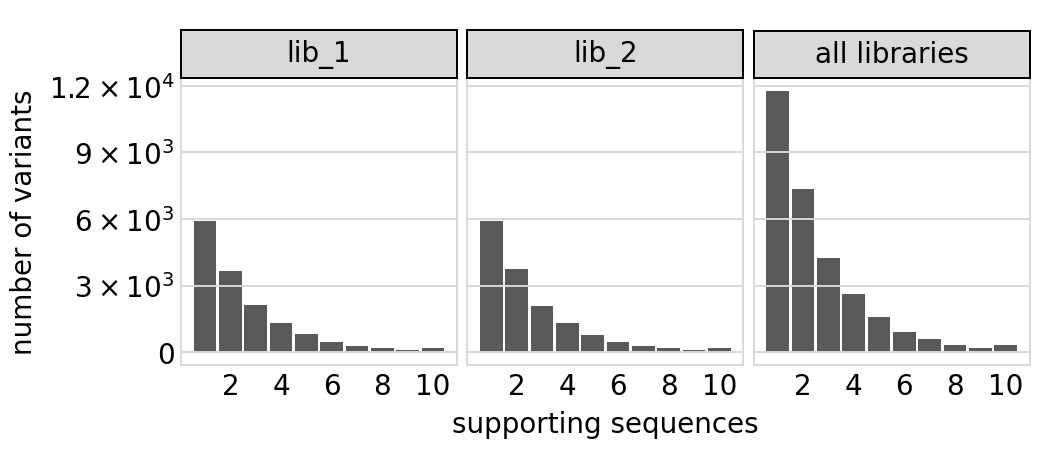

In [15]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotVariantSupportHistogram(max_support=10)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

The set of valid barcodes for each library:

In [16]:
for lib in libs:
    print(f"First few barcodes for library {lib}:")
    print(sorted(variants.valid_barcodes(lib))[:3])

First few barcodes for library lib_1:
['AAAAAACTAAAAGTCG', 'AAAAACAATGCCGCAT', 'AAAAACAGACCTACAA']
First few barcodes for library lib_2:
['AAAAAAACCCAGACTT', 'AAAAAACATCCGATCC', 'AAAAAACCTTCTGCCG']


Plot the number of amino-acid mutations per variant:

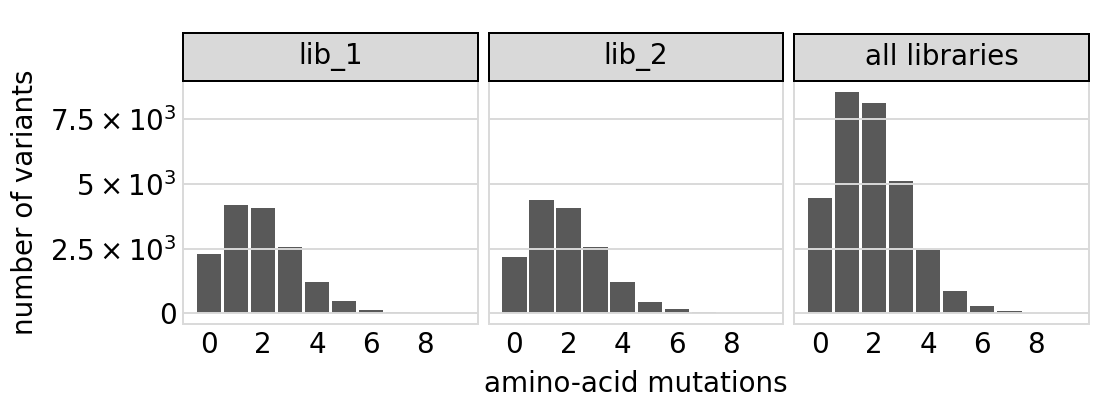

In [17]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotNumMutsHistogram("aa", samples=None)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

Number of codon mutations per variant:

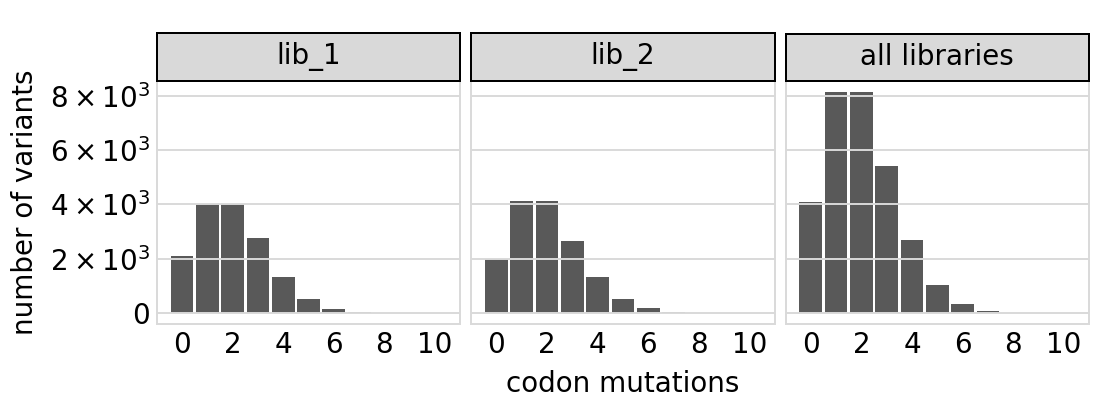

In [18]:
# NBVAL_IGNORE_OUTPUT

p = variants.plotNumMutsHistogram("codon", samples=None)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw(show=True)

Average number of codon mutations per variant of each type of mutation.
We make these plots for:
 1. Just single-mutant and wildtype variants
 2. For all variants

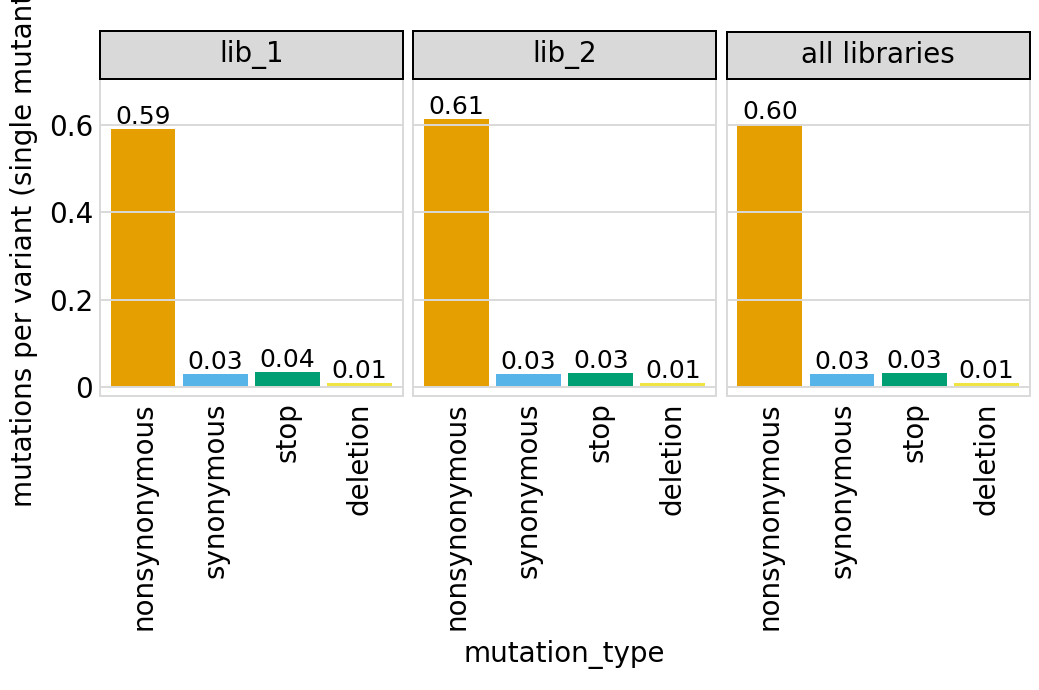

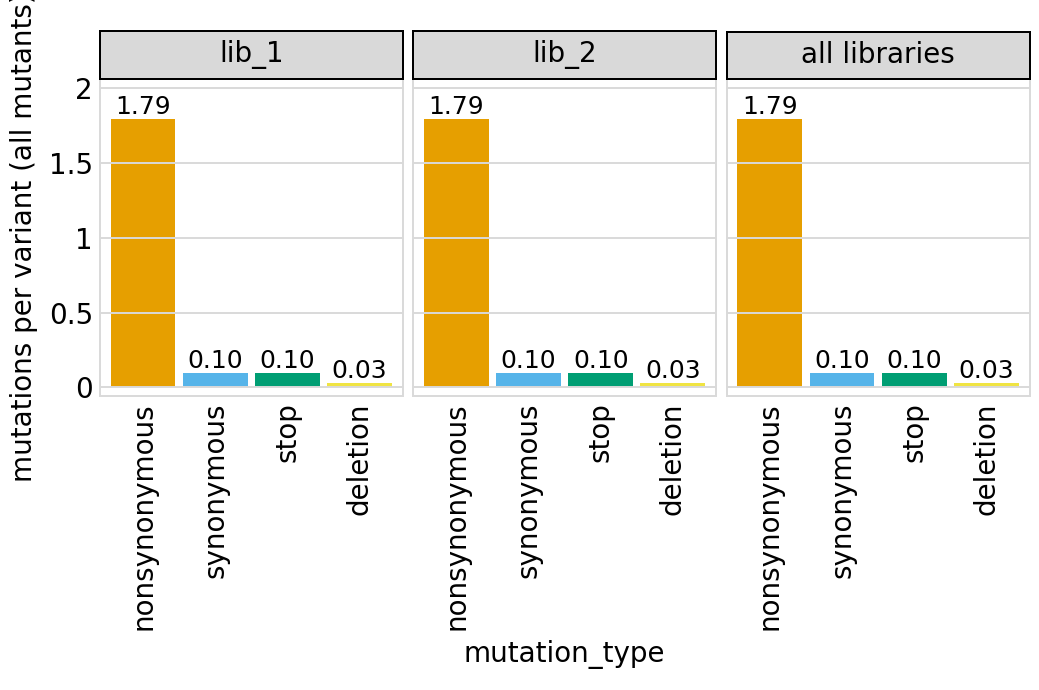

In [19]:
# NBVAL_IGNORE_OUTPUT

for mut_type in ["single", "all"]:
    p = variants.plotNumCodonMutsByType(mut_type, samples=None, heightscale=1.5)
    p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
    _ = p.draw(show=True)

Here are the numerical data in the plots above:

In [20]:
variants.numCodonMutsByType("single", samples=None).round(3)

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,barcoded variants,nonsynonymous,3611,6112,0.591
1,lib_1,barcoded variants,synonymous,194,6112,0.032
2,lib_1,barcoded variants,stop,215,6112,0.035
3,lib_1,barcoded variants,deletion,56,6112,0.009
4,lib_2,barcoded variants,nonsynonymous,3746,6114,0.613
5,lib_2,barcoded variants,synonymous,188,6114,0.031
6,lib_2,barcoded variants,stop,196,6114,0.032
7,lib_2,barcoded variants,deletion,69,6114,0.011
8,all libraries,barcoded variants,nonsynonymous,7357,12226,0.602
9,all libraries,barcoded variants,synonymous,382,12226,0.031


In [21]:
variants.numCodonMutsByType("all", samples=None).round(3)

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,barcoded variants,nonsynonymous,26917,15000,1.794
1,lib_1,barcoded variants,synonymous,1476,15000,0.098
2,lib_1,barcoded variants,stop,1457,15000,0.097
3,lib_1,barcoded variants,deletion,445,15000,0.030
4,lib_2,barcoded variants,nonsynonymous,26919,15000,1.795
5,lib_2,barcoded variants,synonymous,1485,15000,0.099
6,lib_2,barcoded variants,stop,1425,15000,0.095
7,lib_2,barcoded variants,deletion,458,15000,0.031
8,all libraries,barcoded variants,nonsynonymous,53836,30000,1.795
9,all libraries,barcoded variants,synonymous,2961,30000,0.099


Examine how well amino-acid mutations are sampled in the library by looking at the
fraction
of mutations seen <= some number of times.
Here we do that for amino-
acid mutations, making separate plots for single mutants and all mutants:

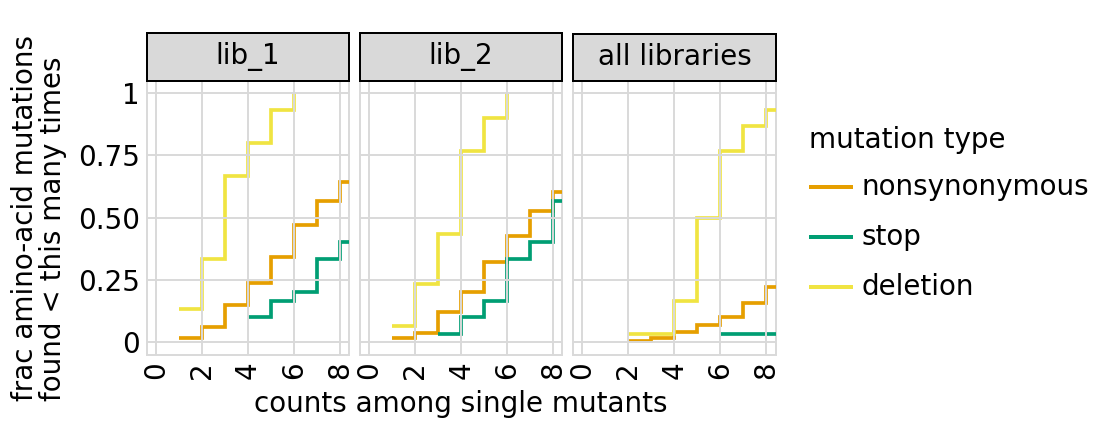

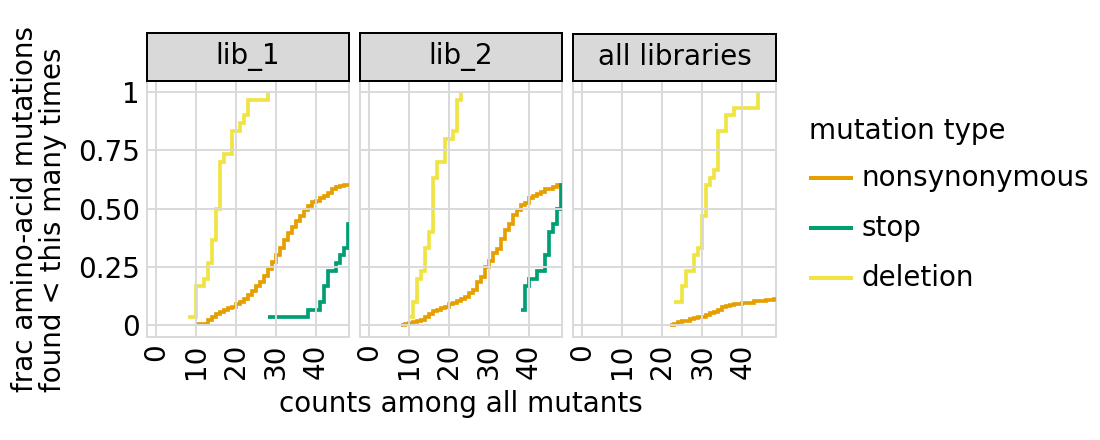

In [22]:
# NBVAL_IGNORE_OUTPUT

for variant_type in ["single", "all"]:
    p = variants.plotCumulMutCoverage(variant_type, mut_type="aa", samples=None)
    _ = p.draw(show=True)

We can also get the numerical information plotted above (here for single mutants
only):

In [23]:
variants.mutCounts("single", "aa", samples=None).head(n=5)

,library,sample,mutation,count,mutation_type,site
0,lib_1,barcoded variants,T9L,24,nonsynonymous,9
1,lib_1,barcoded variants,A7R,21,nonsynonymous,7
2,lib_1,barcoded variants,R1L,21,nonsynonymous,1
3,lib_1,barcoded variants,N10L,20,nonsynonymous,10
4,lib_1,barcoded variants,N27S,20,nonsynonymous,27


Here are the frequencies of mutations along the gene, looking both at single
mutants and all mutants:

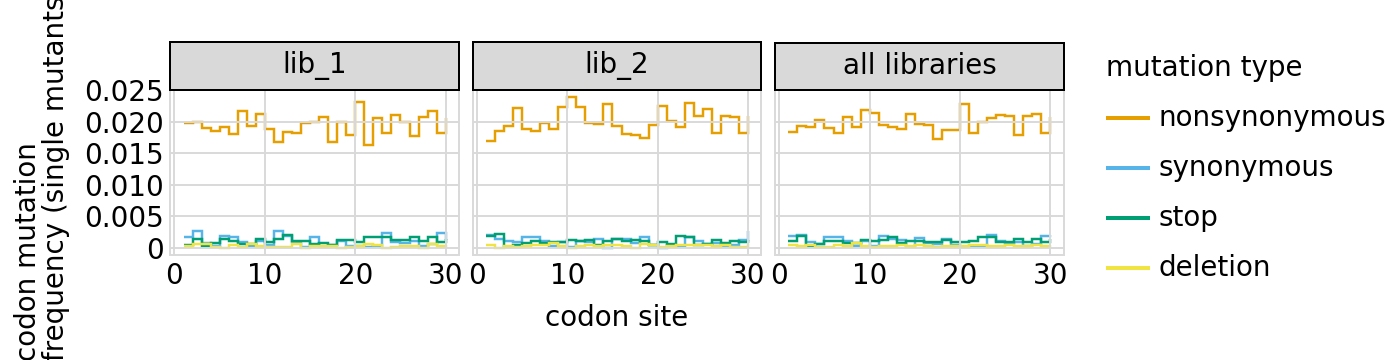

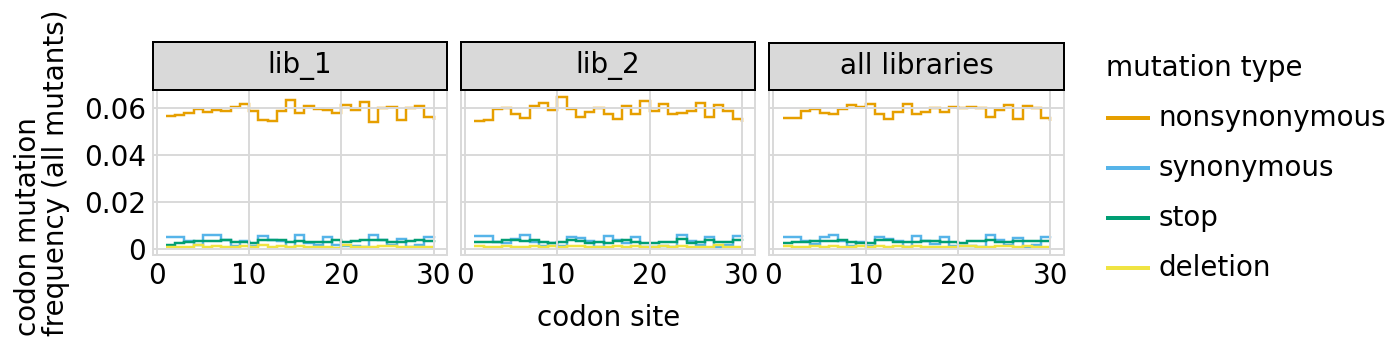

In [24]:
# NBVAL_IGNORE_OUTPUT

for variant_type in ["single", "all"]:
    p = variants.plotMutFreqs(variant_type, "codon", samples=None)
    _ = p.draw(show=True)

We can also look at mutation frequencies in a heat-map form:

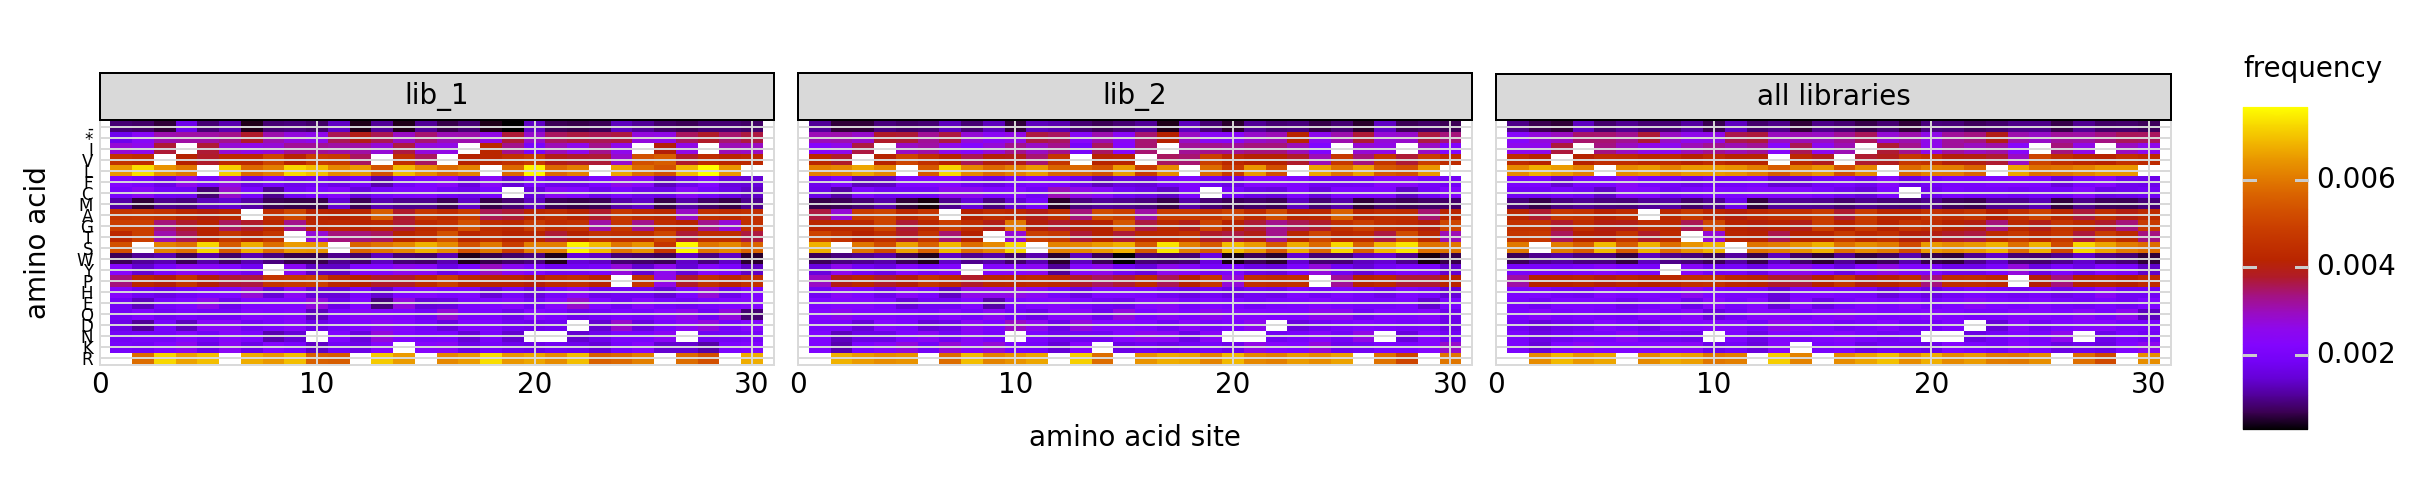

In [25]:
p = variants.plotMutHeatmap("all", "aa", samples=None)
_ = p.draw(show=True)